
# Segmentation with U-Net


 segmentation use-case based on U-Net network (see paper for reference [paper](https://arxiv.org/pdf/1505.04597.pdf)).
 The use-case is based on the initial paper and focuses on cell boundary segmentation, see Fig.1.
<img src="graphics/unet_fig_1.png" width="700"><br>
<center> Figure 1: Left: input image | Right: Prediction of the cell boundaries </center>

## Implementing the code 


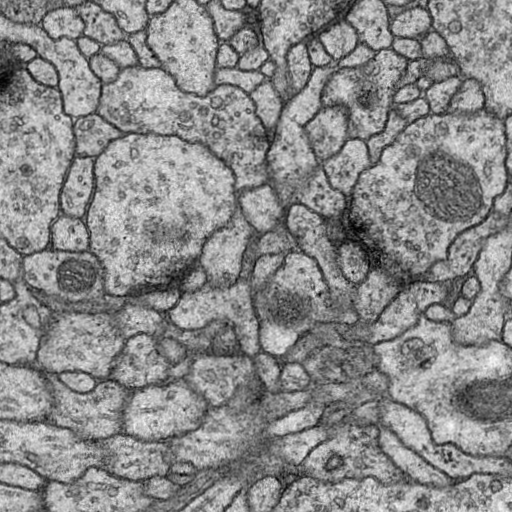

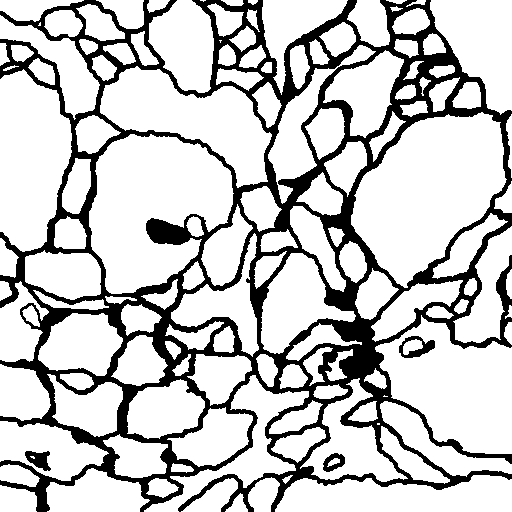

In [20]:

from IPython.display import Image
#to see one of the training data with its label

training_images = 'data/Unet/membrane/train/image/'
training_labels = 'data/Unet/membrane/train/label/'

# the function Image(file_name) used to print the image '0.png' and the label 'o.png'

display(Image(training_images + '0.png'))
display(Image(training_labels + '0.png'))




### Buidling the Unet Architecture

In the next box all libraries  need for the Unet and its dataprepration are imported.

In [21]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os 
import glob
import skimage.io as io 
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

 To build this neural net the following functions are needed:
- 2D Convolution
- MaxPooling 
- Concatenation





Let's start coding the Network with the following functions:

- Conv2D(filters/feature maps, kernel size, activation, padding, kernel_initializer)(input Data)
- MaxPooling2D(pool_size = (x,x))(input Data)
- Dropout(dropout rate)(input Data)
- concatenate([input Data 1, Input Data 2], axis= x)
- Conv2D()(UpSampling2D(size=(x,x))(Input Data)


In [22]:


def unet(input_size=(256, 256, 1)): 
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    # complete the missing layers (your may use copy and past plus adapting)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # In the last layer we chose the <sigmoid> as activation function because the output has to be between zero and one.
     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    # With the following method <Model> we define out input and output of or Neural Network
    
    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
   
    return model

### Preparing the Data

So far the architecture of neural net and the data has been built, consists out of images and labels. To train the neural network in the next step the data has to be prepared.

First of all  define a color map for labels is defined. With this map a specific mask-color for each of the appearing objects will be defined. 
Because we only have one ground truth label, the boundaries of the cell,  a color map is not really needed. But  this code can be used for other task and to familiar with such a Color dicitonary some COLOR_DICT is given below.

In [24]:
# this part below assign the labeling color for the predictions to the labels
# for our purpose it is not really important because we only have "unlabelled" labels, but  to experiment
# with other data this can be used 
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

#### Adjusting the Data

Before feeding the data to neural network, it has to be adjusted properly. 
The first step always helps is to normalize input data. 
This is done by dividing through 255. 
To get the mask as one-hot vector, every mask value > 0.5 should be 1 and every mask value <= 0.5 should be 0. This is done below.

In [25]:

def adjustData(img,mask,num_class):
    if(np.max(img) > 1):
       
        # normalize the image
        img = img / 255
        # normalize the mask 
        mask = mask /255
        # convert your mask vector into a one-hot vector 
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        # mask[mask > __] = __
        # mask[] = __
    return (img,mask)

#### The training Generator

The next function will be the "trainGenerator".This function will do the data augmentation on the given images with functions like rotation, shear and zoom etc. 
The function used here to generate the Data is the ImageDataGenertor provided within Keras. This function takes a dictionary of arguments to augmentate the data. 


In [26]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask"
                   ,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
   
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = 'data/Unet/membrane/train/aug',
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = 'data/Unet/membrane/train/aug',
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    # the generated masks and images are now passed on the function <<adjustData>> discussed beforehand
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,num_class)
        yield (img,mask)
        


#### The Testing Generator 

The testGenerator function will generate the test data on the images provided within the test folder. 
It will first read the images from the test-folder as gray images normalize them and resize them like defined in with the parameter target_size.

In [27]:
def testGenerator(test_path,num_image = 30,target_size = (256,256),as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) 
        img = np.reshape(img,(1,)+img.shape)
        yield img

#### The visualizer of the labels and predictions

In [28]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

#### Saving the results

In [29]:
def saveResult(save_path,npyfile,num_class = 2):
    for i,item in enumerate(npyfile):
        img =item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

## Run the training

In [30]:


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/Unet/membrane/train','image','label',data_gen_args,save_to_dir = None)

model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=300,epochs=5,callbacks=[model_checkpoint])

testGene = testGenerator("data/Unet/membrane/test")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/Unet/membrane/test",results)

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/5
300/300 [==============================] - 732s 2s/step - loss: 0.3931 - accuracy: 0.8099

Epoch 00001: loss improved from inf to 0.33971, saving model to unet_membrane.hdf5
Epoch 2/5
300/300 [==============================] - 716s 2s/step - loss: 0.2871 - accuracy: 0.8926

Epoch 00002: loss improved from 0.33971 to 0.27598, saving model to unet_membrane.hdf5
Epoch 3/5
300/300 [==============================] - 693s 2s/step - loss: 0.2553 - accuracy: 0.9113

Epoch 00003: loss improved from 0.27598 to 0.24997, saving model to unet_membrane.hdf5
Epoch 4/5
300/300 [==============================] - 692s 2s/step - loss: 0.2409 - accuracy: 0.9180

Epoch 00004: loss improved from 0.24997 to 0.23826, saving model to unet_membrane.hdf5
Epoch 5/5
300/300 [==============================] - 689s 2s/step - loss: 0.2306 - accuracy: 0.9227

Epoch 00005: loss improved from 0.23826 to 0.22837, saving model to une

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

## Testing the Model

prediction on the test data and saving them within the test-image folder.

In [31]:
testGene = testGenerator("data/Unet/membrane/test")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/Unet/membrane/test",results)

30/30 [==============================] - 8s 254ms/step


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

### Result

 some images and their predicitons are shown here:


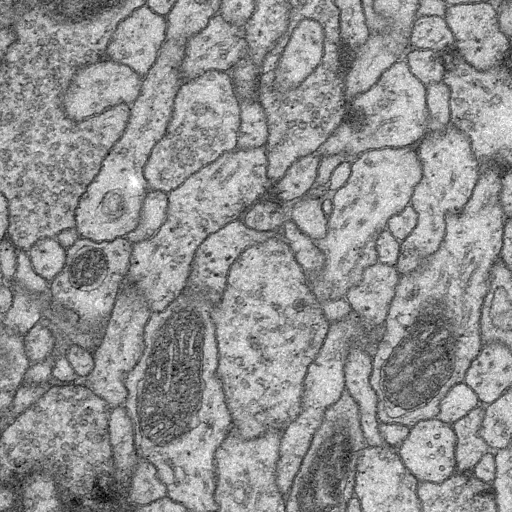

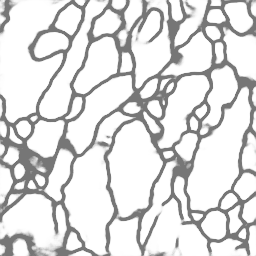

In [35]:
test_path = "data/Unet/membrane/test/"
# number 0 to 29 your want to show
img_number = 20
display(Image(test_path + str(img_number) + '.png'))
display(Image(test_path + str(img_number)  + '_predict.png'))